In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

import renom as rm
from renom.optimizer import Sgd

In [3]:
# Datapath must point to the directory containing the mldata folder.
# data_path = "." # これではエラーになる（今までとデータの配置を変える必要がある f）
data_path = "../dataset"
mnist = fetch_mldata('MNIST original', data_home=data_path)

X = mnist.data
y = mnist.target

# Rescale the image data to 0 ~ 1.
X = X.astype(np.float32)
X /= X.max()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
labels_train = LabelBinarizer().fit_transform(y_train).astype(np.float32)
labels_test = LabelBinarizer().fit_transform(y_test).astype(np.float32)

# Training data size.
N = len(X_train)

In [5]:
class Mnist(rm.Model):

    def __init__(self):
        super(Mnist, self).__init__()
        self._layer1 = rm.Dense(100)
        self._layer2 = rm.Dense(10)
        self._dropout1 = rm.Dropout(dropout_ratio=0.5)

    # 今回のカギとなる Dropout
    def forward(self, x):
        t1 = self._dropout1(self._layer1(x))
        out = self._layer2(t1)
        return out

In [6]:
network = Mnist()

In [7]:
# Hyper parameters
batch = 64
epoch = 50

optimizer = Sgd(lr = 0.01)

learning_curve = []
test_learning_curve = []

for i in range(epoch):
    perm = np.random.permutation(N)
    loss = 0
    for j in range(0, N // batch):
        train_batch = X_train[perm[j * batch:(j + 1) * batch]]
        responce_batch = labels_train[perm[j * batch:(j + 1) * batch]]

        # The computational graph is only generated for this block:
        with network.train():
            l = rm.softmax_cross_entropy(network(train_batch), responce_batch)

        # Back propagation
        grad = l.grad()

        # Update
        grad.update(optimizer)

        # Changing type to ndarray is recommended.
        loss += l.as_ndarray()

    train_loss = loss / (N // batch)

    # Validation
    test_loss = rm.softmax_cross_entropy(network(X_test), labels_test).as_ndarray()
    test_learning_curve.append(test_loss)
    learning_curve.append(train_loss)
    if i % 2 == 0:
        print("epoch %03d train_loss:%f test_loss:%f"%(i, train_loss, test_loss))

epoch 000 train_loss:0.709456 test_loss:0.481503
epoch 002 train_loss:0.403953 test_loss:0.391178
epoch 004 train_loss:0.371083 test_loss:0.372594
epoch 006 train_loss:0.354875 test_loss:0.358276
epoch 008 train_loss:0.342484 test_loss:0.353618
epoch 010 train_loss:0.336847 test_loss:0.336075
epoch 012 train_loss:0.331219 test_loss:0.345314
epoch 014 train_loss:0.329092 test_loss:0.343383
epoch 016 train_loss:0.321310 test_loss:0.335607
epoch 018 train_loss:0.318786 test_loss:0.330723
epoch 020 train_loss:0.316581 test_loss:0.331686
epoch 022 train_loss:0.312764 test_loss:0.325137
epoch 024 train_loss:0.308924 test_loss:0.318669
epoch 026 train_loss:0.306471 test_loss:0.323570
epoch 028 train_loss:0.306508 test_loss:0.325491
epoch 030 train_loss:0.306224 test_loss:0.316099
epoch 032 train_loss:0.303762 test_loss:0.327663
epoch 034 train_loss:0.302485 test_loss:0.326896
epoch 036 train_loss:0.298365 test_loss:0.320815
epoch 038 train_loss:0.298282 test_loss:0.321783
epoch 040 train_loss

In [8]:
network.set_models(inference=True)

[[642   0   4   7   2   6   5   1   1   1]
 [  0 703   4   2   1   1   2   0   5   0]
 [  7   9 637  11  12   3   6   7  15   4]
 [  1   2  13 644   2  20   3  11  16   7]
 [  1   2   2   1 661   1   5   2   6  19]
 [  7   4   3  15   5 554   9   2  24   5]
 [  0   3   4   0   6   9 674   1   4   0]
 [  0   3  11   1   6   1   0 703   2  22]
 [  3  17   9  10   4  19   5   3 609   8]
 [  4   4   0  11  18   8   1  20  11 641]]
             precision    recall  f1-score   support

        0.0       0.97      0.96      0.96       669
        1.0       0.94      0.98      0.96       718
        2.0       0.93      0.90      0.91       711
        3.0       0.92      0.90      0.91       719
        4.0       0.92      0.94      0.93       700
        5.0       0.89      0.88      0.89       628
        6.0       0.95      0.96      0.96       701
        7.0       0.94      0.94      0.94       749
        8.0       0.88      0.89      0.88       687
        9.0       0.91      0.89      

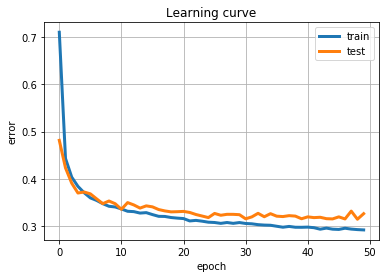

In [9]:
predictions = np.argmax(network(X_test).as_ndarray(), axis=1)

# Confusion matrix and classification report.
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

# Learning curve.
plt.plot(learning_curve, linewidth=3, label="train")
plt.plot(test_learning_curve, linewidth=3, label="test")
plt.title("Learning curve")
plt.ylabel("error")
plt.xlabel("epoch")
plt.legend()
plt.grid()
plt.show()